# Module 04: Assignment for 2-Dimensional Landscape Evolution Model

## Name: Sarah Jones
## Due: 10-26-2021

### Overview and Requirements

In this assignment you will examine the long term behavior of the elevation field under two different assumptions about the landscape diffusivity (i.e., the variable controlling soil creep). Use the code below to conduct the following experiments:

__Experiment 1:__ Using the code below conduct an experiment that leaves everything unchanged, except `tf` which you should increase to 100,000 yrs and increasing the plotting output interval (`OutputInterval`) to 20,000 years. Run the model and also create an array that is `Nt` in length to store the maximum elevation in the 2-D domain at each time step. You will need to use the `.max` function on `hnext` to obtain this inside the main `for` loop of the model.

__Experiment 2:__ Using the same setup as you did for Experiment 1 above, now _decrease_ the diffusivity `D` by an order of magnitude and re-run the model, again keeping track of the maximum elevation in the domain at each modeling time step. 

The notebook you turn in should have the following plots:
* The maximum elevation versus time for both experiments on the same plot
* The 3D plot containing topographic surfaces at every 20,000 year interval for __Experiment 1__ (clearly labelled)
* The 3D plot containing topographic surfaces at every 20,000 year interval for __Experiment 2__ (clearly labelled)

Answer the following question:
* How does changing the diffusivity change the evolution of the maximum elevation in each experiment? 
* If we were to allow Experiments 1 and 2 to run for an infinite amount of time, how would the topographic surface between the experiments? What would be the only difference between the two topographies?

### Setup Initial Conditions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

hi = 100.0  # Initial elevation (m)
D_e1 = 2.5  # Diffusivity for experiment 1 (m^2/yr)
D_e2 = 0.25 # Diffusivity for experiment 2 (m^2/yr)

ti = 0.0      # Initial time (yr)
tf = 100000.0 # Final time(yr)
dt = 5        # Time step(yr)

U = 0.005 # Uplift rate (m/yr)

# Plotting options
individual_plots = 0 # If 1, individual plot at every output interval, all stacked otherwise
OutputInterval = 20000.0 # Plot only at these intervals (yr)

Nt = (tf - ti)/dt + 1 # Number of time data points

Noutput = (tf - ti)/OutputInterval + 1 # Number of plot locations in time


# Define coordinates for plotting
xMax = yMax = 500.0  # Max limits of x and y axis
xMin = yMin = 0.0    # Min limits of x and y axis
Nx = Ny = 50         # Step size in x and y axis

x = np.linspace(xMin,xMax,Nx)
y = np.linspace(yMin,yMax,Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

X, Y = np.meshgrid(x,y)

### Setup the Solver Matrix

In [2]:
N = Nx*Ny

ind = np.linspace(0,N-1,N)
Ind = np.linspace(0,N-1,N).reshape((Ny,Nx))

# Setup solver matrix for use in implicit solution
Delta2 = np.matrix(np.diagflat(-4.0*np.ones((int(N),1)),k=0) + np.diagflat(np.ones((int(N-1),1)),k=1) \
    + np.diagflat(np.ones((int(N-1),1)),k=-1) + np.diagflat(np.ones((int(N-Nx),1)),k=int(Nx)) \
    + np.diagflat(np.ones((int(N-Ny),1)),k=-(int(Ny))))


### Compute the Stability Variable - Experiment 1

In [3]:
alpha_e1 = D_e1*dt/dx**2  # Stability variable
print("alpha = ",alpha_e1)
print("dt = ",dt)
print("dx = ",dx)
if alpha_e1 >= 0.5:
    raise Exception("Stability criteria error in alpha_e1! Either decrease dt or increase dx!")


alpha =  0.12005000000000002
dt =  5
dx =  10.204081632653061


### Setup the Boundary Conditions - Experiment 1

In this problem, the boundary conditions are a little more complex. We will assume that the elevation at the corder of our square domain remain fixed throughout the simulation. But the rest of the area along the edges of the domain can evolve. 

What we need to do to allow this is actually first solve the 1-D problem once (using the same $\Delta x$, $D$, $\Delta t$, and simulation duration) on the edges of the domain with fixed edges, and then use that solution at every time step along ___all four___ edges of the domain. 

In [4]:
# Initialize boundary conditions for corners
NBound = np.array(Ind[0,:])
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])

# Now compute the boundary conditions on the sides of the domain as the temporal evolution of a 1D
# profile in response to a lowering of head on 1-side of the domain

# Calculate the 1D solution for Experiment 1
Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))

H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))

H_1D[:,0] = np.matrix(h0_1D)

for i in range(1,int(Nt)):
    hinit_1D = H_1D[:,i-1] 
        
    hnext_1D = hinit_1D + alpha_e1*Delta2_1D*hinit_1D + U*dt
    hnext_1D[0] = hi
    hnext_1D[-1] = hi

    H_1D[:,i] = hnext_1D[:,0]

### Run the Model - Experiment 1

Now we need to run the model. Here we use an explicit approach to the solution, but we pose it as a linear algebra matrix-vector multiplication (i.e., we don't have to invert the matrix $\mathbf{A}$. We will create a 3-D plot at fixed intervals along the simulation... it's too much to visualize each timestep. You can control how often plots are created using the variable `OutputInterval`. 

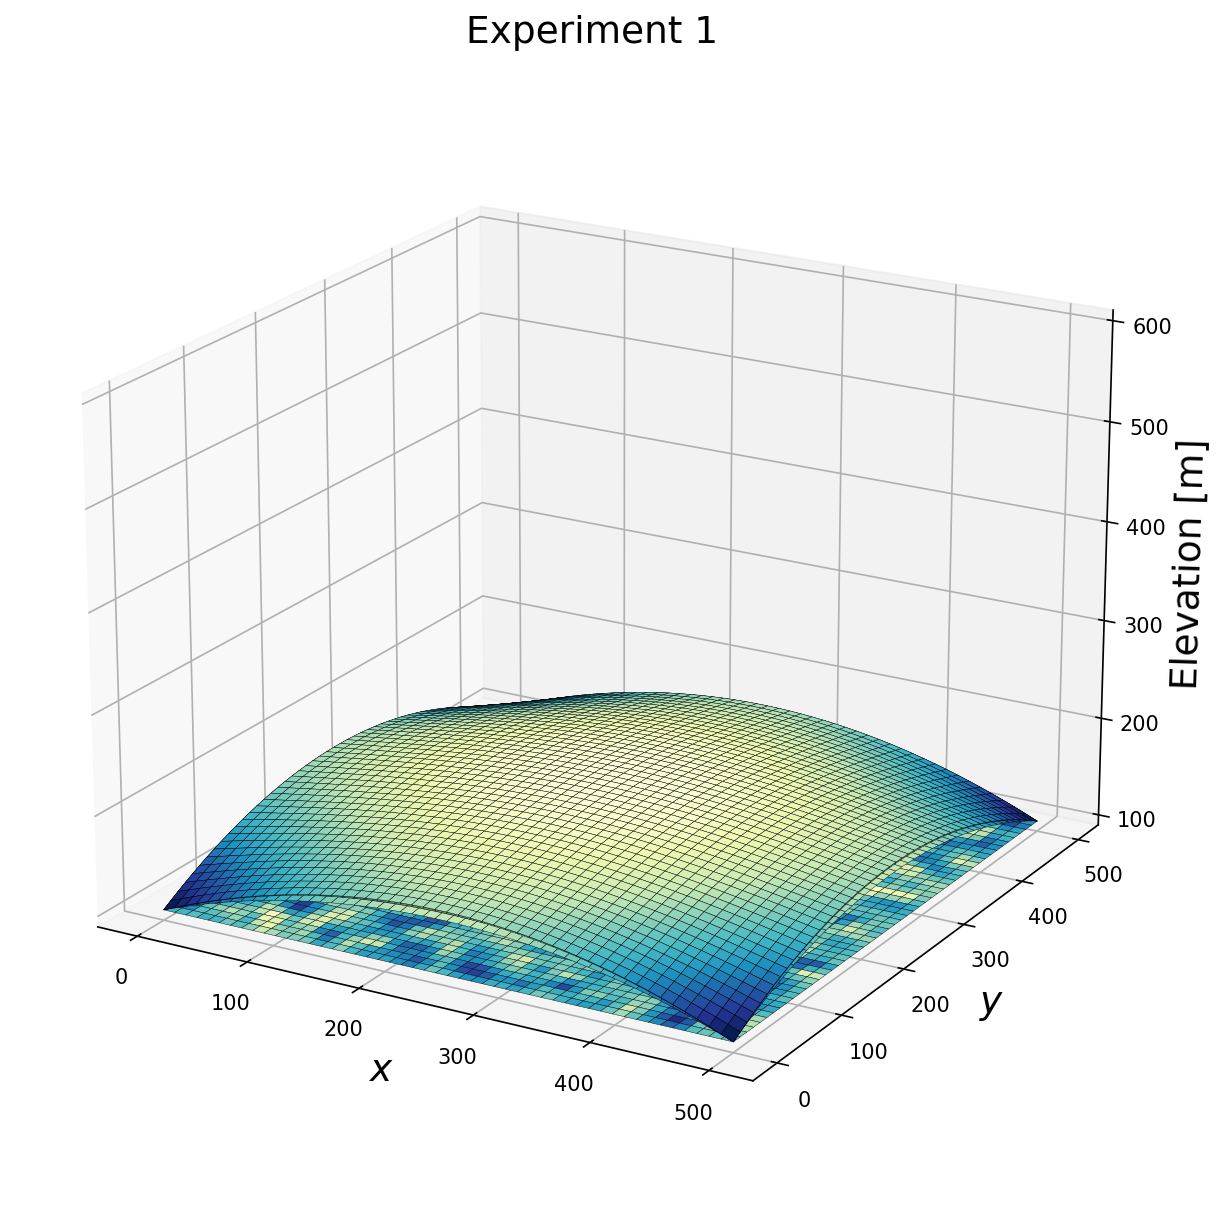

In [5]:
import matplotlib as mpl

h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1) 
hnext = np.matrix(h0)

elev_max_e1 = np.ones(int(Nt))  # Initialize array to store max elevation values for each time step in experiment 1
elev_max_e1[0] = hnext.max()    # Set initial value for max elevation

figcounter = 1

# Calculate the 2D solution for Experiment 1
for i in range(1,int(Nt)):
    hinit = hnext + U*dt
    
    hnext = hinit + alpha_e1*Delta2*hinit 
    
    elev_max_e1[i] = hnext.max() # Calculate and store max elevation for time step

    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i] 
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    
    # Plot the 2D solution for Experiment 1
    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title('Experiment 1', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='YlGnBu_r',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, hi+U*dt*Nt)
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1

plt.show()

### Experiment 2

In [6]:
# Repeat Experiment 1 with a new value of diffusivity
# Don't need to re-initialize most variables - only calculate things that changes based on D

alpha_e2 = D_e2*dt/dx**2 # Stability variable
print("alpha_e2 = ",alpha_e2)
if alpha_e2 >= 0.5:
    raise Exception("Stability criteria error in alpha_e2! Either decrease dt or increase dx!")
    
# Initialize boundary conditions for corners
NBound = np.array(Ind[0,:])
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])

# Calculate the 1D solution for Experiment 2
Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))

H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))

H_1D[:,0] = np.matrix(h0_1D)

for i in range(1,int(Nt)):
    hinit_1D = H_1D[:,i-1] 
        
    hnext_1D = hinit_1D + alpha_e2*Delta2_1D*hinit_1D + U*dt
    hnext_1D[0] = hi
    hnext_1D[-1] = hi

    H_1D[:,i] = hnext_1D[:,0]

alpha_e2 =  0.012005000000000002


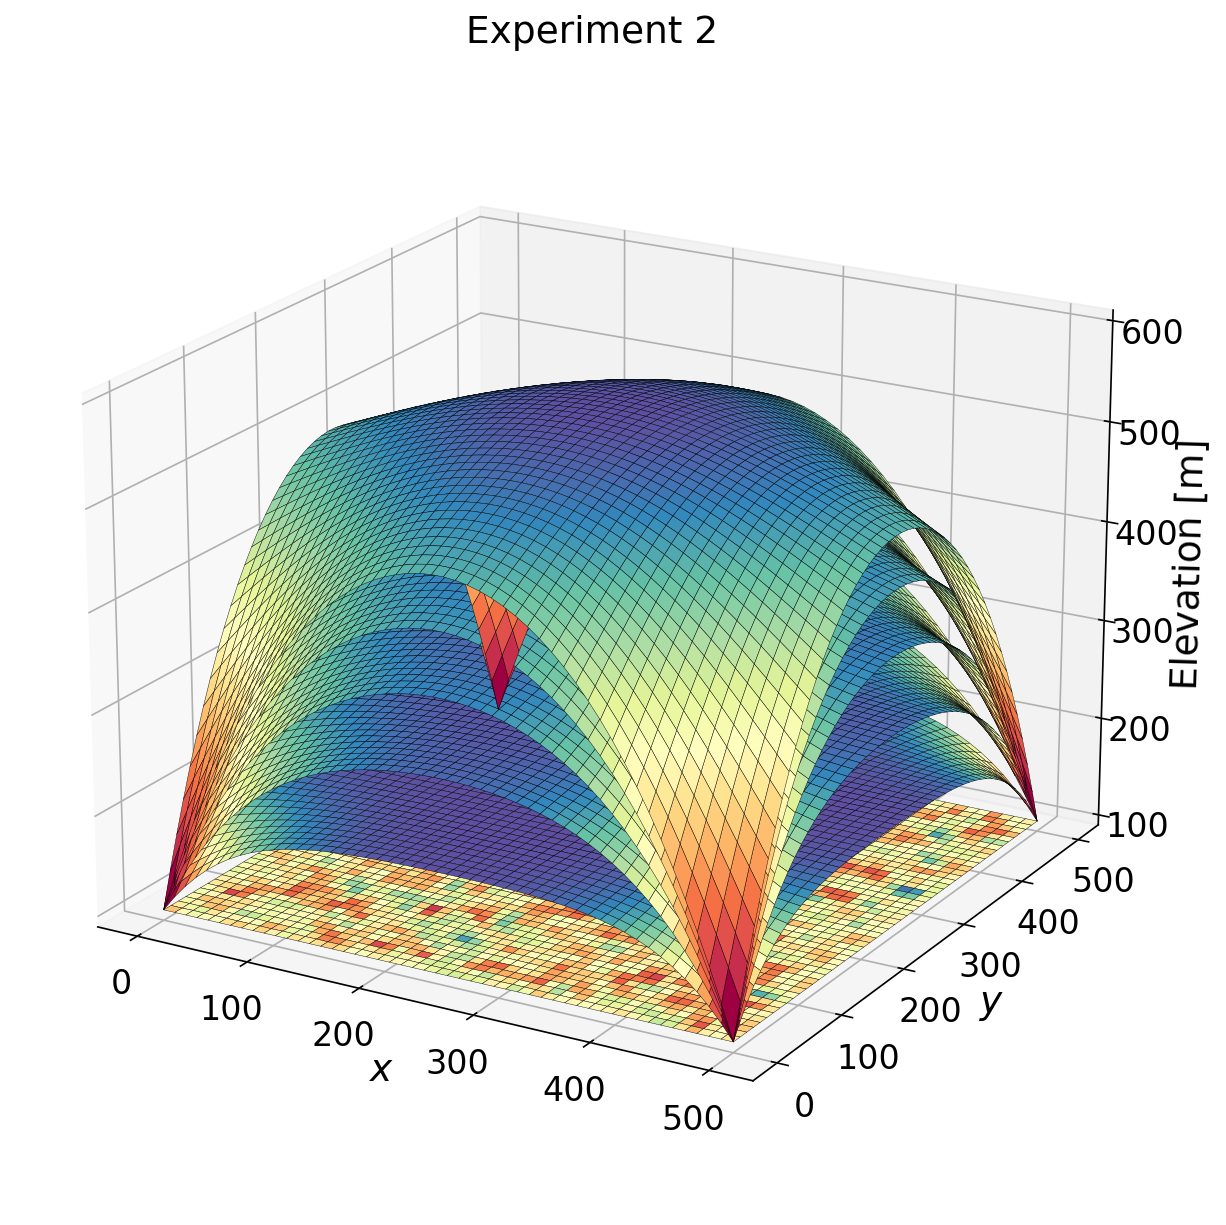

In [7]:
h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1) 
hnext = np.matrix(h0)

elev_max_e2 = np.ones(int(Nt)) # Initialize array to store max elevation values for each time step in experiment 2 
elev_max_e2[0] = hnext.max()   # Set initial value for max elevation

figcounter = 1

# Calculate 2D solution for experiment 2
for i in range(1,int(Nt)):
    hinit = hnext + U*dt
    
    hnext = hinit + alpha_e2*Delta2*hinit 
    
    elev_max_e2[i] = hnext.max() # Calculate and store max elevation for time step

    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i] 
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    
    # Plot 2D solution for experiment 2
    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
                ax.set_title('Experiment 2', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='Spectral',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, hi+U*dt*Nt)
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1

plt.show()

### Comparison of Max Elevation

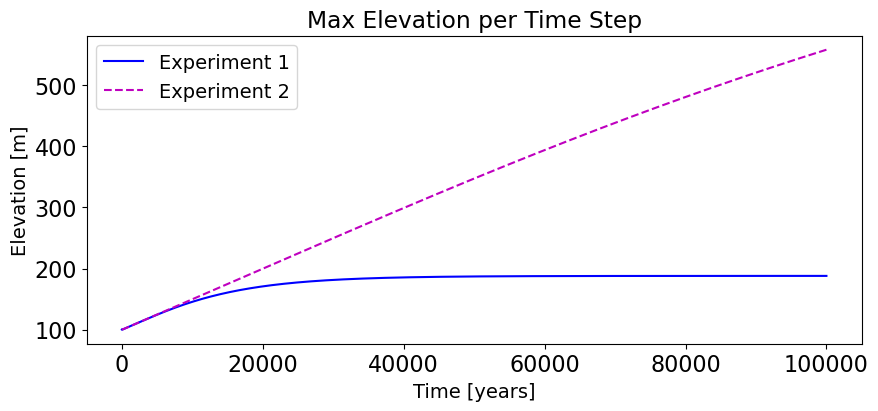

In [8]:
t = np.arange(ti,tf+dt,dt) # Time data points for plotting purposes

plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
plt.plot(t,elev_max_e1,'b-', label= 'Experiment 1')
plt.plot(t,elev_max_e2,'m--', label = 'Experiment 2')
plt.xlabel('Time [years]')
plt.ylabel('Elevation [m]')
plt.legend()
plt.title('Max Elevation per Time Step')
plt.show()

### Questions

1. How does changing the diffusivity change the evolution of the maximum elevation in each experiment? 
    - Changing the diffusivity changes the evolution of the maximum elevation by changing what the maximum uplift of the soil (and therefore the limit of max elevation) will be. A lower diffusivity means the soil can reach a higher level of uplift, whereas a smaller diffusivity means the soil will have a lower maximum value of uplift. Furthermore, since we did not change the uplift rate between the experiments, the higher diffusivity in experiment 1 will allow the maximum uplift to be reached sooner than in experiment 2.


2. If we were to allow Experiments 1 and 2 to run for an infinite amount of time, how would the topographic surface between the experiments? What would be the only difference between the two topographies?
    - If we allowed the experiments to run for an infinite amount of time, both experiments would reach their maximum uplift value. The only difference between the two topographies would be the scale and therefore also the slopes at the corners that are confined.